File Download

In [ ]:
!wget https://raw.githubusercontent.com/Suppersine/Thesis2021/main/taxiuber/uberday.csv

--2021-08-19 07:52:46--  https://raw.githubusercontent.com/Suppersine/Thesis2021/main/taxiuber/uberday.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1376 (1.3K) [text/plain]
Saving to: ‘uberday.csv’

uberday.csv         100%[===================>]   1.34K  --.-KB/s    in 0s      

2021-08-19 07:52:46 (62.8 MB/s) - ‘uberday.csv’ saved [1376/1376]



Library

In [ ]:
# LSTM for international airline passengers problem with regression framing
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

convert an array of values into a dataset matrix

In [ ]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(7)

Data Plot & preparation

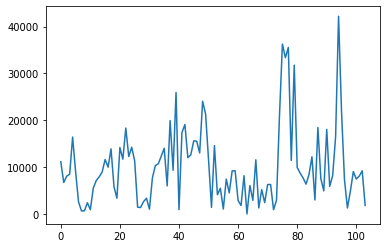

In [ ]:
# load the dataset
dataframe = pd.read_csv('uberday.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

dataplot = dataframe.copy()
#training_set = pd.read_csv('shampoo.csv')

#dataplot = dataplot.iloc[:,1:2].values

#plt.plot(training_set, label = 'Shampoo Sales Data')
plt.plot(dataplot, label = 'Taxi Daily Ridership Data (104/01-08)')
plt.show()

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
#here, you can change the test size to make future prediction
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


Model & Training

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=1, verbose=2)

Epoch 1/200
67/67 - 8s - loss: 0.0496
Epoch 2/200
67/67 - 0s - loss: 0.0292
Epoch 3/200
67/67 - 0s - loss: 0.0225
Epoch 4/200
67/67 - 0s - loss: 0.0206
Epoch 5/200
67/67 - 0s - loss: 0.0202
Epoch 6/200
67/67 - 0s - loss: 0.0200
Epoch 7/200
67/67 - 0s - loss: 0.0200
Epoch 8/200
67/67 - 0s - loss: 0.0201
Epoch 9/200
67/67 - 0s - loss: 0.0200
Epoch 10/200
67/67 - 0s - loss: 0.0199
Epoch 11/200
67/67 - 0s - loss: 0.0198
Epoch 12/200
67/67 - 0s - loss: 0.0198
Epoch 13/200
67/67 - 0s - loss: 0.0198
Epoch 14/200
67/67 - 0s - loss: 0.0199
Epoch 15/200
67/67 - 0s - loss: 0.0198
Epoch 16/200
67/67 - 0s - loss: 0.0197
Epoch 17/200
67/67 - 0s - loss: 0.0198
Epoch 18/200
67/67 - 0s - loss: 0.0197
Epoch 19/200
67/67 - 0s - loss: 0.0196
Epoch 20/200
67/67 - 0s - loss: 0.0196
Epoch 21/200
67/67 - 0s - loss: 0.0197
Epoch 22/200
67/67 - 0s - loss: 0.0195
Epoch 23/200
67/67 - 0s - loss: 0.0195
Epoch 24/200
67/67 - 0s - loss: 0.0197
Epoch 25/200
67/67 - 0s - loss: 0.0195
Epoch 26/200
67/67 - 0s - loss: 0.

Prediction & RMSE calculation

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 5823.53 RMSE
Test Score: 10244.89 RMSE


Testing Data & Plot

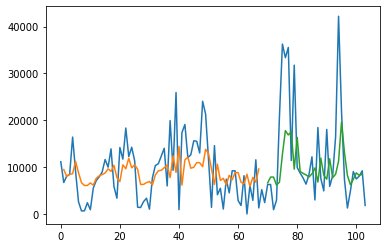

In [ ]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()